# Prompt & Probe plots

Assumes output data is in `fingerprints/`

Load data

In [ ]:
import pandas as pd
from pathlib import Path

BASE = Path("./fingerprints")

def load_fingerprints(base=BASE):
    """Load all fingerprint CSVs from fingerprints/*.csv."""
    rows = []

    for file in base.glob("*.csv"):
        model_id = file.stem   # filename without extension
        print(f"Loading: {model_id}")

        df = pd.read_csv(file)
        df["model_id"] = model_id

        # extract seed from filenames like name[q-8bit][seed=3]
        if "seed=" in model_id:
            seed_str = model_id.split("seed=")[-1]
            seed = int(seed_str.replace("]", ""))
        else:
            seed = -1   # e.g. baseline / seedless old files

        df["seed"] = seed
        rows.append(df)

    return pd.concat(rows, ignore_index=True)

df = load_fingerprints()
df = df[df['prompt_length'] < 4000]
df.head()


Average seeds, fit linear model, and report statistics

In [ ]:
import numpy as np
import re
import pandas as pd

# group all seed runs into TRUE model families
def get_family(model_id):
    # remove [seed=N]
    return re.sub(r"\[seed=\d+\]", "", model_id)

df["family"] = df["model_id"].apply(get_family)

# compute averaged data per model family
fits = {}

for family, sub in df.groupby("family"):

    # average over seeds at each prompt length
    avg_sub = sub.groupby("prompt_length", as_index=False)["peak_vram_mb"].mean()

    X = avg_sub["prompt_length"].values
    y = avg_sub["peak_vram_mb"].values

    # fit the constrained linear model y = a*x + b through first point
    x0, y0 = X[0], y[0]
    X_shift = X - x0
    y_shift = y - y0

    a = np.sum(X_shift * y_shift) / np.sum(X_shift ** 2)
    b = y0 - a * x0

    # fit diagnostics
    y_pred = a * X + b
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot
    mape = np.mean(np.abs((y - y_pred) / y)) * 100

    fits[family] = dict(a=a, b=b, r2=r2, mape=mape)


# 3. Print fitted models
for model_id, vals in fits.items():
    print(model_id)
    print(f"  slope a     = {vals['a']:.6f}")
    print(f"  intercept b = {vals['b']:.6f}")
    print(f"  R²          = {vals['r2']:.4f}")
    print(f"  MAPE        = {vals['mape']:.2f}%\n")


Llama-3.1-8B[q-8bit]
  slope a     = 0.952489
  intercept b = 9276.835022
  R²          = 0.8255
  MAPE        = 4.69%

Llama-3.2-1B[fp16]
  slope a     = 0.984359
  intercept b = 2610.971282
  R²          = 0.8555
  MAPE        = 11.34%

Llama-3.2-1B[q-8bit]
  slope a     = 0.960685
  intercept b = 1759.018630
  R²          = 0.8436
  MAPE        = 15.62%

Llama-3.2-3B[fp16]
  slope a     = 0.830485
  intercept b = 6387.219031
  R²          = 0.8976
  MAPE        = 3.95%

Llama-3.2-3B[q-8bit]
  slope a     = 0.800321
  intercept b = 3795.279358
  R²          = 0.8807
  MAPE        = 6.50%

Mistral-7B-Instruct-v0.2[q-8bit]
  slope a     = 2.030392
  intercept b = 7718.073216
  R²          = 0.9624
  MAPE        = 2.60%

Mistral-7B-v0.1[q-8bit]
  slope a     = 1.364860
  intercept b = 7719.404281
  R²          = 0.9651
  MAPE        = 2.22%

Qwen2-7B-Instruct[q-8bit]
  slope a     = 0.835117
  intercept b = 8889.269766
  R²          = 0.8283
  MAPE        = 4.28%

gemma-2b[fp16]
  slope

Case study: See fit for the two Mistral versions

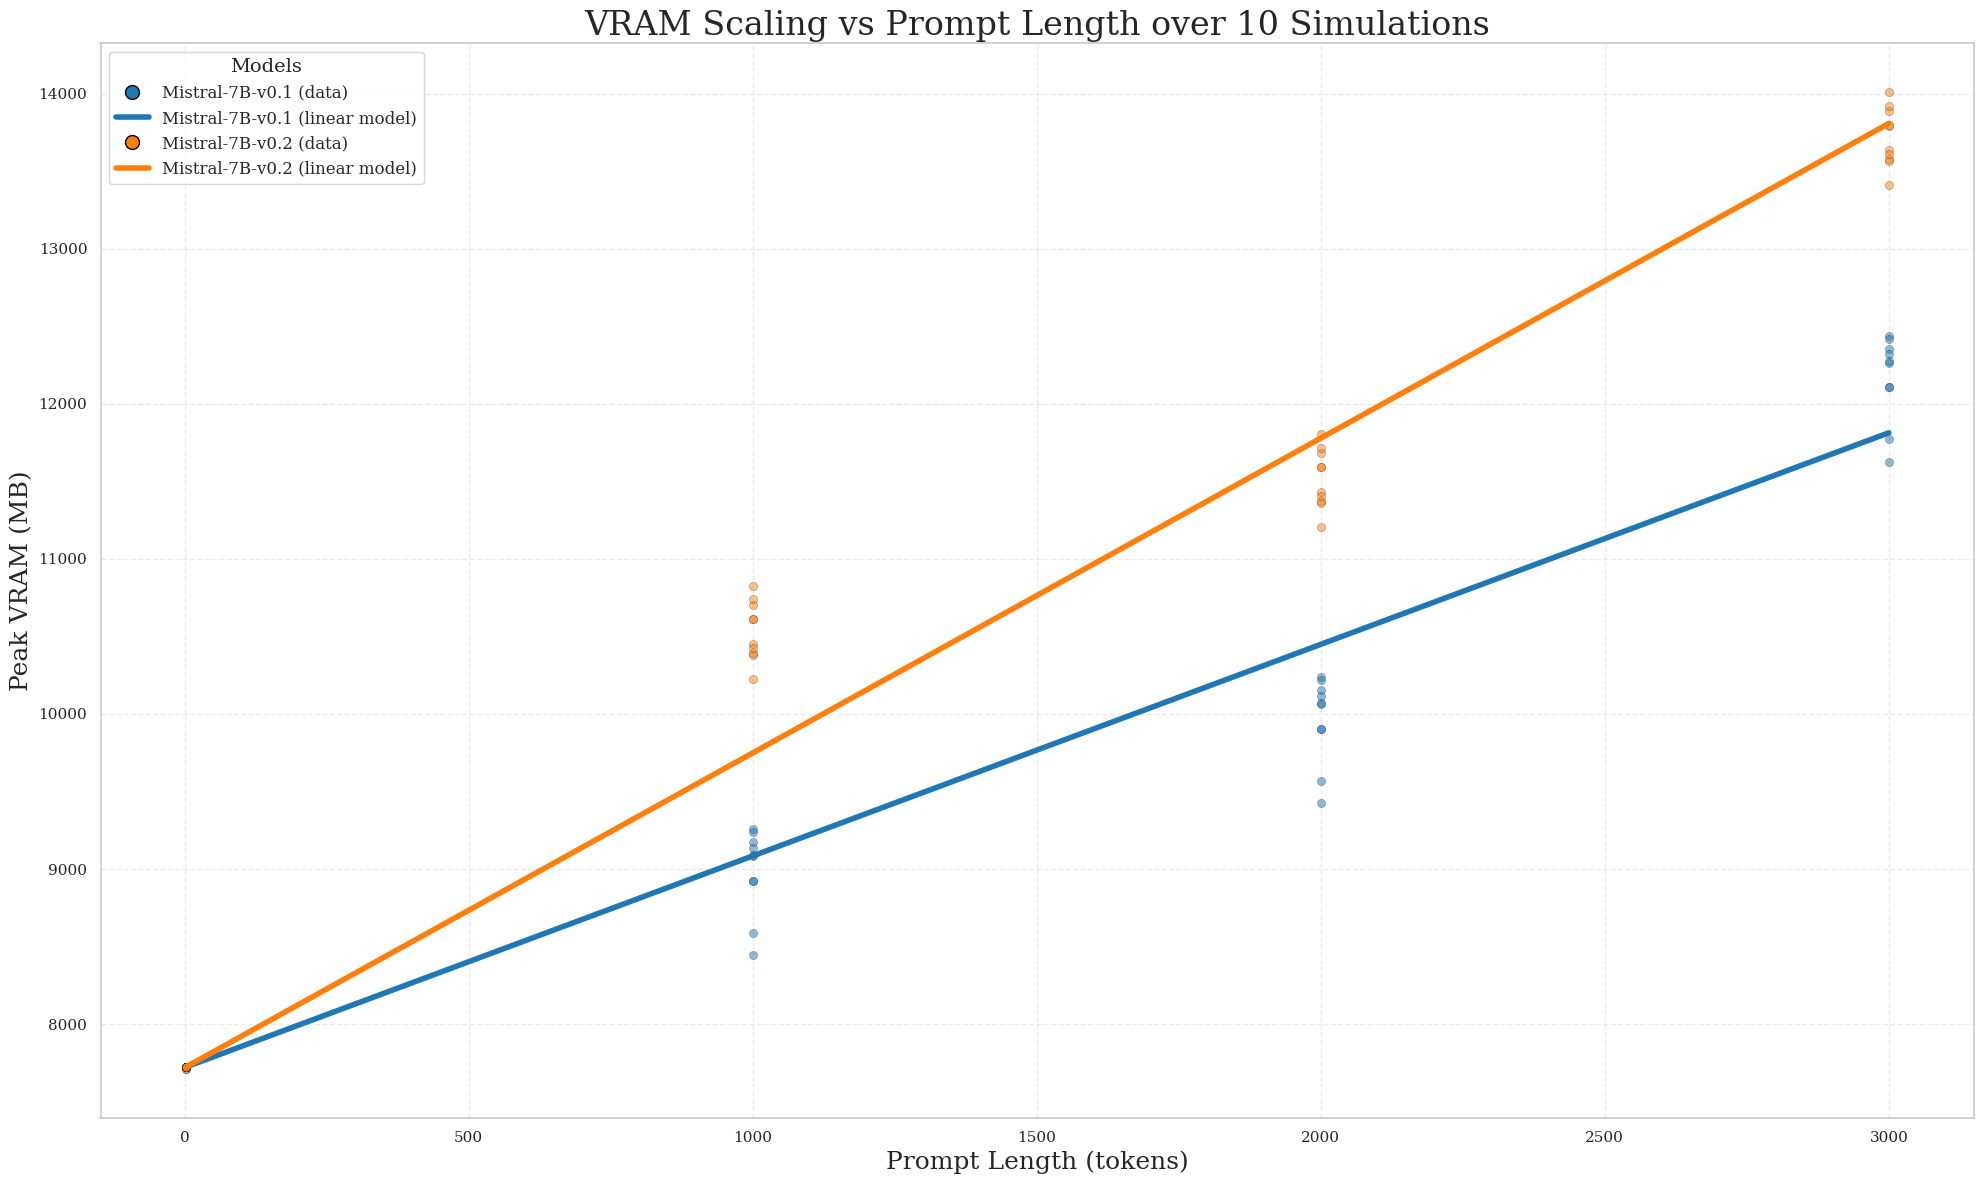

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# only keep mistral, case-insensitive
mistral_df = df[df["model_id"].str.contains("mistral", case=False)].copy()

sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"

plt.figure(figsize=(20, 12))

# Two mistral families
families = {
    "v0.1": "Mistral-7B-v0.1",
    "v0.2": "Mistral-7B-Instruct-v0.2"
}

palette = sns.color_palette("tab10", n_colors=2)
family_colors = { "v0.1": palette[0], "v0.2": palette[1] }

# For legend proxies
legend_scatter = {}
legend_lines = {}

for fam_key, fam_base in families.items():

    fam_color = family_colors[fam_key]

    # extract all seed runs for this family
    fam_runs = mistral_df[mistral_df["model_id"].str.contains(fam_base, regex=False)]

    # Scatter each seed run separately (NO LEGEND ENTRY)
    for model_id, sub in fam_runs.groupby("model_id"):
        X = sub["prompt_length"]
        y = sub["peak_vram_mb"]

        plt.scatter(
            X, y,
            s=35,
            alpha=0.5,
            edgecolor="black",
            linewidth=0.3,
            color=fam_color,
            label=None 
        )

    # mean slope/intercept line
    fam_fits = [vals for mid, vals in fits.items() if fam_base in mid]
    a_mean = np.mean([ff["a"] for ff in fam_fits])
    b_mean = np.mean([ff["b"] for ff in fam_fits])

    Xall = fam_runs["prompt_length"]
    xs = np.linspace(Xall.min(), Xall.max(), 300)
    ys = a_mean * xs + b_mean

    plt.plot(
        xs, ys,
        color=fam_color,
        linewidth=4,
        label=None
    )

    # Create proxy legend items for this family
    legend_scatter[fam_key] = plt.Line2D(
        [], [], marker='o', linestyle='None',
        markersize=10, color=fam_color, markeredgecolor="black"
    )

    legend_lines[fam_key] = Line2D(
        [], [], color=fam_color, linewidth=4
    )

# Build final legend entries manually
legend_elements = [
    (legend_scatter["v0.1"], "Mistral-7B-v0.1 (data)"),
    (legend_lines["v0.1"],   "Mistral-7B-v0.1 (linear model)"),
    (legend_scatter["v0.2"], "Mistral-7B-v0.2 (data)"),
    (legend_lines["v0.2"],   "Mistral-7B-v0.2 (linear model)")
]

plt.legend(
    handles=[x[0] for x in legend_elements],
    labels=[x[1] for x in legend_elements],
    fontsize=12,
    title="Models",
    title_fontsize=14,
    frameon=True
)

plt.xlabel("Prompt Length (tokens)", fontsize=18)
plt.ylabel("Peak VRAM (MB)", fontsize=18)
plt.title("VRAM Scaling vs Prompt Length over 10 Simulations", fontsize=24)

plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


Plot fingerprints

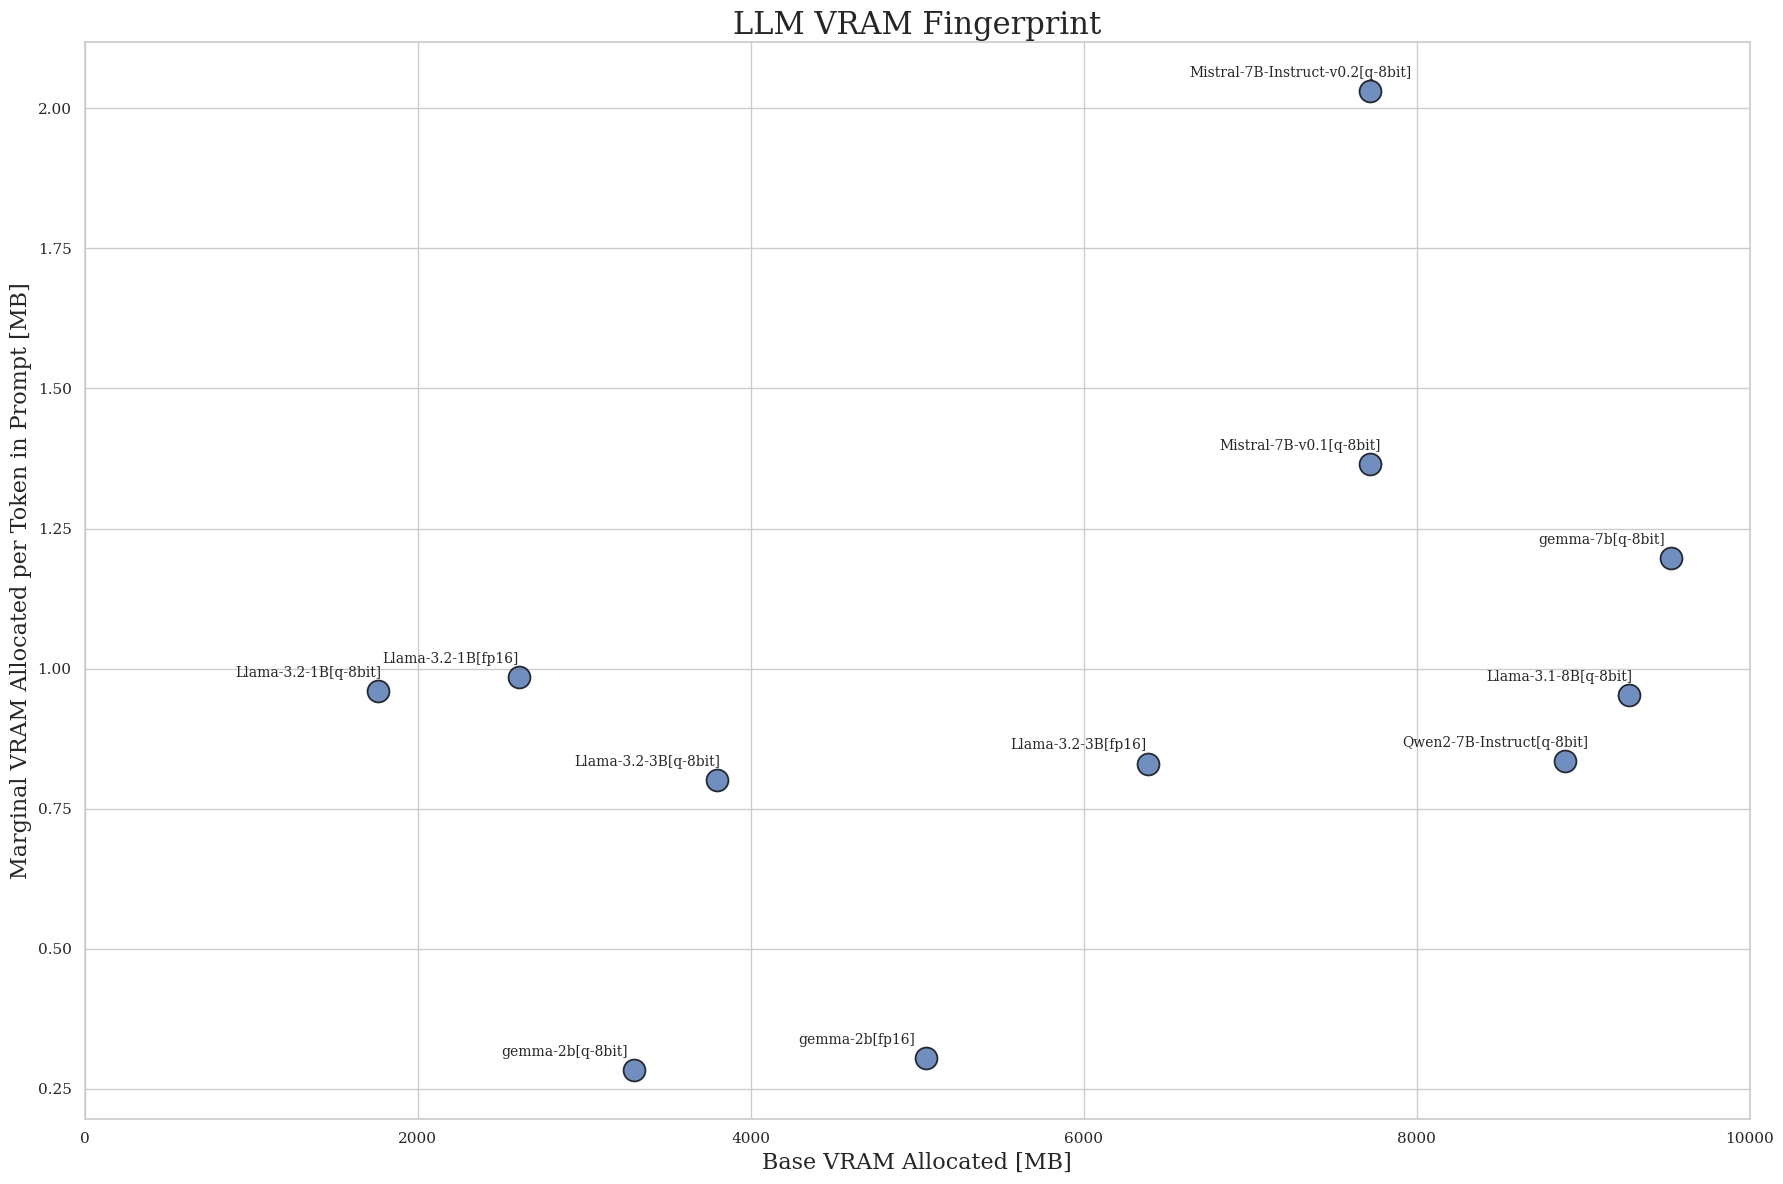

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# average slopes and intercepts per model family
import re
import pandas as pd

records = []

for model_id, vals in fits.items():
    # Extract seed
    m = re.search(r"seed=(\d+)", model_id)
    seed = int(m.group(1)) if m else None

    # Extract model family (remove seed tag)
    family = re.sub(r"\[seed=\d+\]", "", model_id)

    records.append({
        "family": family,
        "a": vals["a"],
        "b": vals["b"],
    })

tmp = pd.DataFrame(records)

# average slope/intercept across ALL seeds for each model family
avg = tmp.groupby("family", as_index=False).mean()

# replace plotting variables with averaged values
model_ids = avg["family"].tolist()
slopes     = avg["a"].tolist()
intercepts = avg["b"].tolist()


sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"


plt.figure(figsize=(18, 12))

# scatter plot with seaborn styling
sns.scatterplot(
    x=intercepts,
    y=slopes,
    s=250,
    color="C0",
    edgecolor="black",
    alpha=0.8
)

# add text labels
texts = []
for model, b, a in zip(model_ids, intercepts, slopes):
    plt.annotate(
        model,
        xy=(b, a), # anchor: point
        xytext=(-50, 8), # shift 8 px upward
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xlim(left=0, right=10000)
plt.xlabel("Base VRAM Allocated [MB]", fontsize=16)
plt.ylabel("Marginal VRAM Allocated per Token in Prompt [MB]", fontsize=16)
plt.title("LLM VRAM Fingerprint", fontsize=22)

plt.tight_layout()
plt.show()
